In [ ]:
# using PyCall

# @pyimport sspy.filters as filters
# @pyimport sspy.smoothers as smoothers

# println(filters.KalmanFilter)
# println(smoothers.KalmanSmoother)

INFO: Recompiling stale cache file C:\Users\wil\.julia\lib\v0.6\PyPlot.ji for module PyPlot.


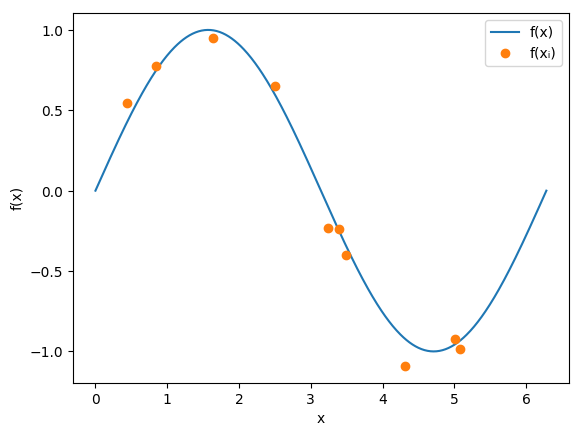

PyObject <matplotlib.legend.Legend object at 0x00000000299F58D0>

In [2]:
using PyPlot

nₜ, nₛ = 600, 10 # number of time points, samples

x = linspace(0,2π,nₜ)
𝐟 = sin.(x)

𝐑 = 0.1 ^ 2

𝒊ₓ = sort!(1 + round.(Int, nₜ * rand(nₛ)))

xᵢ = x[𝒊ₓ]

𝐟ᵢ = 𝐟[𝒊ₓ] + chol(𝐑) * randn(nₛ)

plot(x,𝐟,"-",xᵢ,𝐟ᵢ,"o")
xlabel("x"), ylabel("f(x)")
legend(labels=["f(x)","f(xᵢ)"])

In [ ]:
function gp() 
    q, λ = 1., 1.

    k(x,x_) = (q/2λ) * exp(-λ*abs(x - x_))

    𝐊ʸʸ, 𝐊ᶠʸ, 𝐊ᶠᶠ = zeros(nₛ, nₛ), zeros(nₜ, nₛ), zeros(nₜ, nₜ)

    for 𝑖 ∈ 1:nₛ
        for 𝑗 ∈ 1:nₛ
            𝐊ʸʸ[𝑖,𝑗] = k(xᵢ[𝑖],xᵢ[𝑗])
        end
    end

    𝐊ʸʸ += 𝐑 * eye(nₛ)

    for 𝑖 ∈ 1:nₜ
        for 𝑗 ∈ 1:nₛ
            𝐊ᶠʸ[𝑖,𝑗] = k(x[𝑖],xᵢ[𝑗])
        end
    end

    for 𝑖 ∈ 1:nₜ
        for 𝑗 ∈ 1:nₜ
            𝐊ᶠᶠ[𝑖,𝑗] = k(x[𝑖],x[𝑗])
        end
    end

    𝛍 = (𝐊ᶠʸ / 𝐊ʸʸ) * 𝐟ᵢ
    𝚺 = diag(𝐊ᶠᶠ - (𝐊ᶠʸ / 𝐊ʸʸ) * 𝐊ᶠʸ')
    
    return 𝛍, 𝚺
end


gp (generic function with 1 method)

In [ ]:
function plot_estimate(𝛍, 𝚺)
    figure()
    plot(x,𝐟,"-",xᵢ,𝐟ᵢ,"o")

    𝗖𝗜 = [𝛍 𝛍] + 1.96*[-sqrt.(𝚺) sqrt.(𝚺)]

    plot(x,𝛍,"r--")
    fill_between(x,𝗖𝗜[:,1],𝗖𝗜[:,2],alpha=0.5)

    xlabel("x"), ylabel("f(x)")
    legend(labels=["f(x)","f(xᵢ)"])
end

plot_estimate (generic function with 1 method)

In [ ]:
Δₜ = x[2] - x[1]

function kf()
    q, λ = 1., 1.
    
    μ₀,Σ₀ = 0., q/2λ
    
    𝐅 = exp(-Δₜ * λ)
    𝐐 = (q/2λ) * (1 - exp(-2Δₜ * λ))
    
    𝛍 = zeros(nₜ)
    𝚺 = zeros(nₜ)
    
    μ, σ² = μ₀, Σ₀
    𝛍[1],𝚺[1] = μ, σ²
    
    𝑖 = 1
    for t ∈ 2:nₜ
        # predict
        μ, σ² = 𝐅*μ, 𝐅*σ²*𝐅' + 𝐐
        
        if t ∈ 𝒊ₓ
            𝐊ₜ = σ² / (σ² + 𝐑)
            μ  += 𝐊ₜ * (𝐟ᵢ[𝑖] - μ)
            σ² -= 𝐊ₜ * (σ² + 𝐑) * 𝐊ₜ'
            𝑖 += 1
        end
        𝛍[t] = μ
        𝚺[t] = σ²
    end
    
    return 𝛍, 𝚺
end

function rts(𝛍, 𝚺)
    q, λ = 1., 1.
    
    𝐅 = exp(-Δₜ * λ)
    𝐐 = (q/2λ) * (1 - exp(-2Δₜ * λ))
    
    for t ∈ nₜ-1:-1:1
        
        μ = 𝛍[t]
        σ²= 𝚺[t]
        
        μ⁺, σ²⁺ = 𝐅*μ, 𝐅*σ²*𝐅' + 𝐐
        
        𝐆ₜ = σ² * 𝐅' / σ²⁺
        
        𝛍[t] += 𝐆ₜ * (𝛍[t+1] - μ⁺)
        𝚺[t] += 𝐆ₜ * (𝚺[t+1] - σ²⁺) * 𝐆ₜ'
    end
    
    return 𝛍, 𝚺
end

rts (generic function with 1 method)

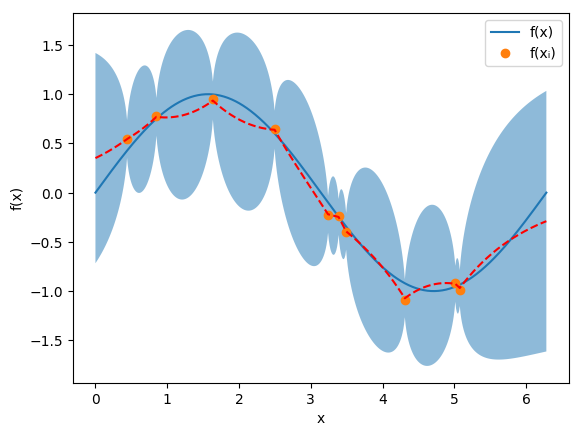

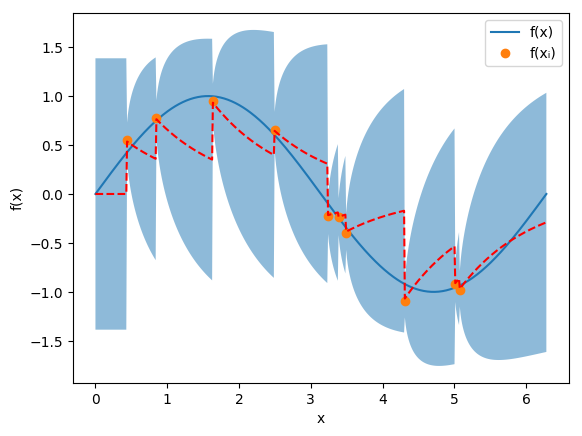

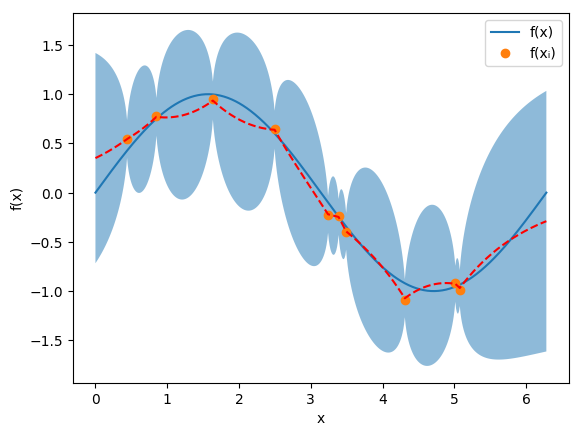

PyObject <matplotlib.legend.Legend object at 0x0000000029B233C8>

In [6]:
𝛍, 𝚺 = gp()
plot_estimate(𝛍, 𝚺)

𝛍, 𝚺 = kf()
plot_estimate(𝛍, 𝚺)

𝛍, 𝚺 = rts(𝛍, 𝚺)
plot_estimate(𝛍, 𝚺)

In [7]:
using BenchmarkTools

function kfs()
    𝛍, 𝚺 = kf()
    𝛍, 𝚺 = rts(𝛍, 𝚺)
    return 𝛍, 𝚺
end



print(@benchmark gp())
println()
print(@benchmark kfs())
println()
print(@benchmark mean(𝐟))

Trial(90.087 ms)
Trial(352.146 μs)
Trial(164.645 ns)